In [ ]:
!pip install openpyxl
!pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 905.7 kB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import openpyxl
import xlsxwriter

import statsmodels.api as sm
from scipy.stats import ttest_rel, false_discovery_control
from scipy.stats import shapiro, anderson, wilcoxon, chi2_contingency, contingency, pointbiserialr

from collections import namedtuple
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab_Notebooks/oai/TKR_twin'

Mounted at /content/drive
/content/drive/MyDrive/Colab_Notebooks/oai/TKR_twin


In [ ]:
# Set the random seed for reproducibility
np.random.seed(42)

In [ ]:
def load_and_merge_data(full_data_path, match_data_path, merge_key, selected_columns):
    full_df = pd.read_csv(full_data_path)
    match_df = pd.read_csv(match_data_path, usecols=selected_columns)
    merged_df = pd.merge(match_df, full_df, on=merge_key, how='left')
    return merged_df


selected_columns = ['distance','id']

oa_inc_matched_df = load_and_merge_data(
    'publish_dataframes/oa_inc_multiple_imputation_filled.csv',
    'publish_dataframes/rand_state_oa_inc_matchit_TSNE_EuclideanDist_Replacement_df.csv',
    'id',
    selected_columns
)

tkr_matched_df = load_and_merge_data(
    'publish_dataframes/tkr_multiple_imputation_filled.csv',
    '/content/drive/MyDrive/Colab_Notebooks/oai/TKR_twin/better_TKR_match_TSNE/rand_state_tkr_matchit_TSNE_EuclideanDist_Replacement_df.csv',
    'id',
    selected_columns
)

# oa_inc_matched_df.to_csv('publish_dataframes/rand_state_oa_inc_matched_IDs_PC_modes.csv', index=False)
# tkr_matched_df.to_csv('publish_dataframes/rand_state_tkr_matched_IDs_PC_modes.csv', index=False)

In [ ]:
# Before Matching
# OA Incidence example usage
oa_inc_before_match = pd.read_csv('publish_dataframes/oa_inc_multiple_imputation_filled.csv')
numerical_cols = oa_inc_before_match.iloc[:,16:-110].columns.tolist()
categorical_cols = oa_inc_before_match.iloc[:,7:16].columns.tolist()

tkr_before_match = pd.read_csv('publish_dataframes/tkr_multiple_imputation_filled.csv')
numerical_cols = tkr_before_match.iloc[:,16:-110].columns.tolist()
categorical_cols = tkr_before_match.iloc[:,7:16].columns.tolist()

In [ ]:
# After Matching

# numerical_cols = oa_inc_matched_df.iloc[:,17:-110].columns.tolist()
# categorical_cols = oa_inc_matched_df.iloc[:,8:17].columns.tolist()

# numerical_cols = tkr_matched_df.iloc[:,17:-110].columns.tolist()
# categorical_cols = tkr_matched_df.iloc[:,8:17].columns.tolist()

In [ ]:
!unzip "/content/drive/MyDrive/Colab_Notebooks/oai/control_used_for_embedding/Noto_Serif.zip"


Archive:  /content/drive/MyDrive/Colab_Notebooks/oai/control_used_for_embedding/Noto_Serif.zip
replace OFL.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
  inflating: NotoSerif-Regular.ttf   
replace NotoSerif-Italic.ttf? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace NotoSerif-Bold.ttf? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace NotoSerif-BoldItalic.ttf? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
!mv NotoSerif-Regular.ttf /usr/share/fonts/truetype/

**Love Plots**

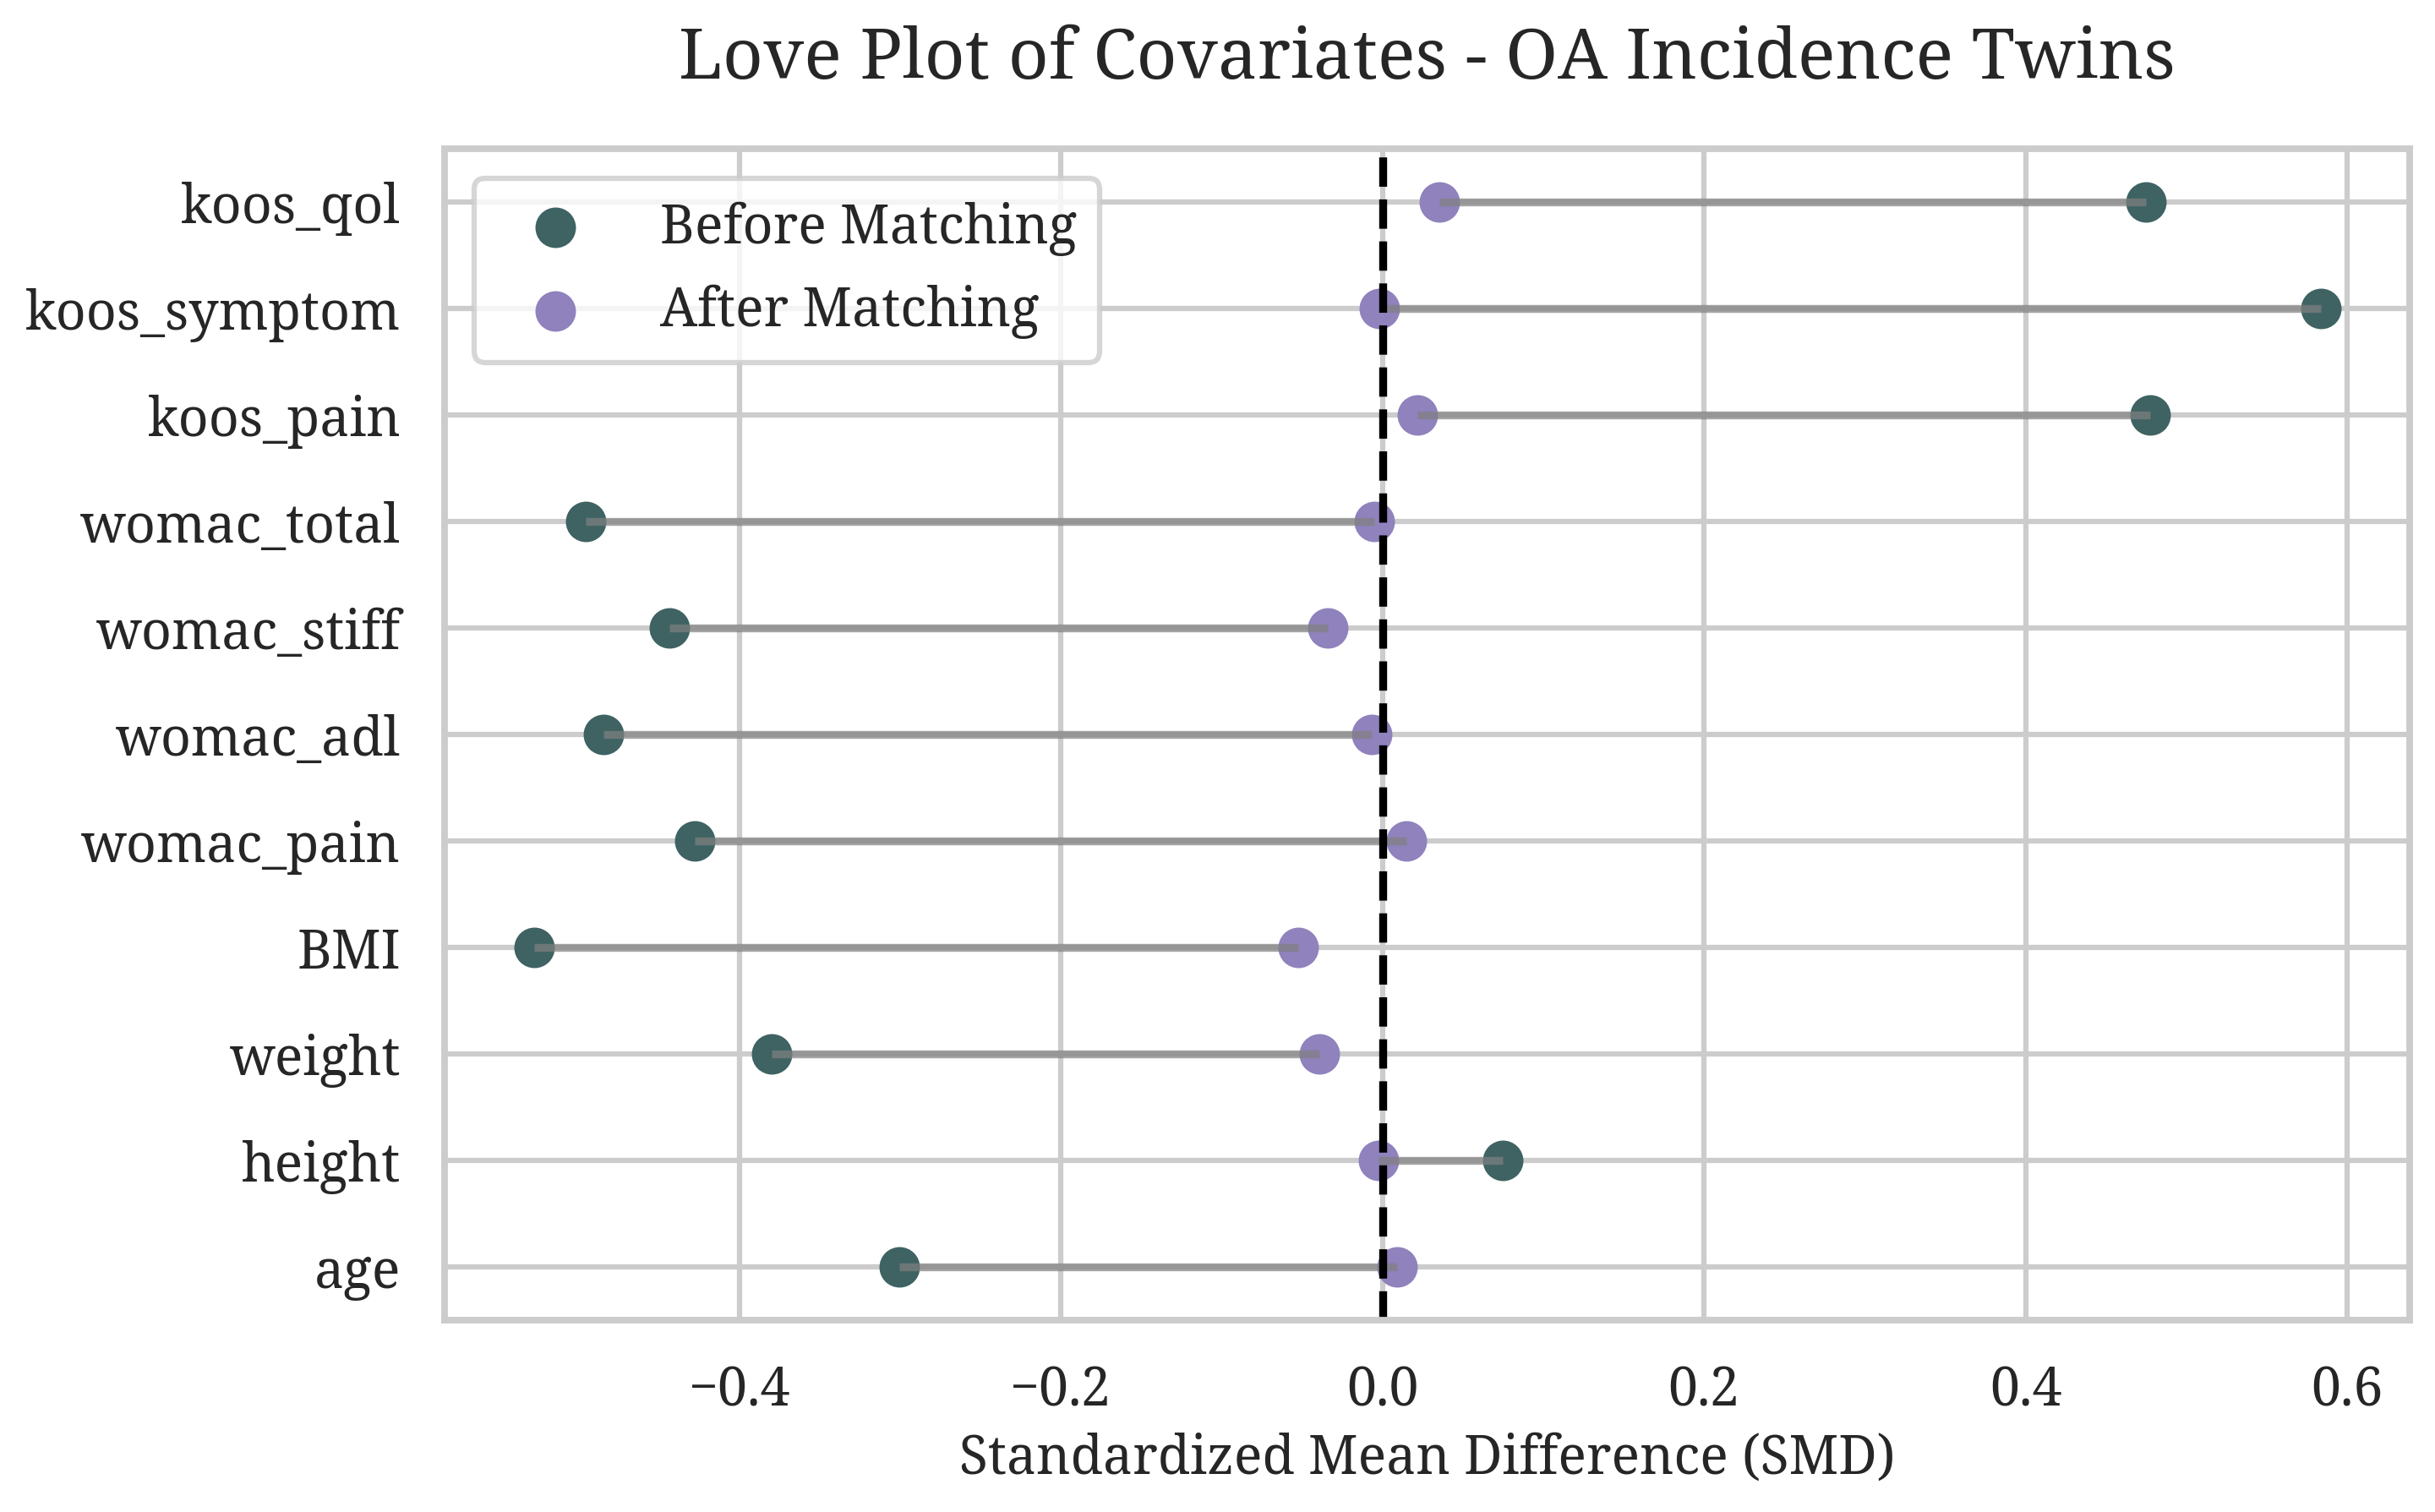

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.font_manager as fm
path = '/usr/share/fonts/truetype/NotoSerif-Regular.ttf'
fontprop = fm.FontProperties(fname=path, size= 15)

sns.set_context("talk")
sns.set_style("whitegrid")

after_color = '#8f82bd'
before_color = '#3f6263'

df_before = oa_inc_before_match.iloc[:,16:-110]
df_after = oa_inc_matched_df.iloc[:,17:-110]

# Separate df_before into control and treatment groups
df_before_control = oa_inc_before_match[oa_inc_before_match['oa_prog'] == 0]
df_before_treatment = oa_inc_before_match[oa_inc_before_match['oa_prog'] == 1]

# Separate df_after into control and treatment groups
df_after_control = oa_inc_matched_df[oa_inc_matched_df['oa_prog'] == 0]
df_after_treatment = oa_inc_matched_df[oa_inc_matched_df['oa_prog'] == 1]

# df_before and df_after should have the same structure and the same covariates
covariates = df_before.columns  # list of covariate names

def standardized_mean_difference(df1, df2, variable):
    """Calculate the standardized mean difference for a variable."""
    mean1, mean2 = df1[variable].mean(), df2[variable].mean()
    pooled_std = np.sqrt((df1[variable].std()**2 + df2[variable].std()**2) / 2)
    return (mean1 - mean2) / pooled_std

# Calculate SMD for each covariate before and after matching
smd_before = [standardized_mean_difference(df_before_control, df_before_treatment, var) for var in covariates]
smd_after = [standardized_mean_difference(df_after_control, df_after_treatment, var) for var in covariates]

# Creating the love plot
# plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
ax.hlines(y=covariates, xmin=smd_before, xmax=smd_after, color='grey', alpha=0.7)
ax.scatter(smd_before, covariates, color=before_color, alpha=1, label='Before Matching',  s=100)
ax.scatter(smd_after, covariates, color=after_color, alpha=1, label='After Matching',  s=100)
ax.axvline(x=0, color='black', linestyle='--')

# Plot settings
plt.xlabel('Standardized Mean Difference (SMD)', fontproperties=fontprop)
plt.title('Love Plot of Covariates - OA Incidence Twins', fontproperties=fontprop, fontsize=20, pad=20)
plt.legend()

plt.setp(ax.get_legend().get_texts(),fontproperties=fontprop) # legend text
plt.setp(ax.get_legend().get_title(), fontproperties=fontprop)

# If you want to change the font family for tick labels:
for label in ax.get_xticklabels():
    label.set_fontproperties(fontprop)
for label in ax.get_yticklabels():
    label.set_fontproperties(fontprop)

# plt.savefig('/content/drive/MyDrive/Colab_Notebooks/oai/figures/OA_Inc_numerical_Love_plot.svg', format='svg', bbox_inches='tight')
# plt.savefig('/content/drive/MyDrive/Colab_Notebooks/oai/figures/grid_OA_Inc_numerical_Love_plot.svg', format='svg', bbox_inches='tight')

plt.show()

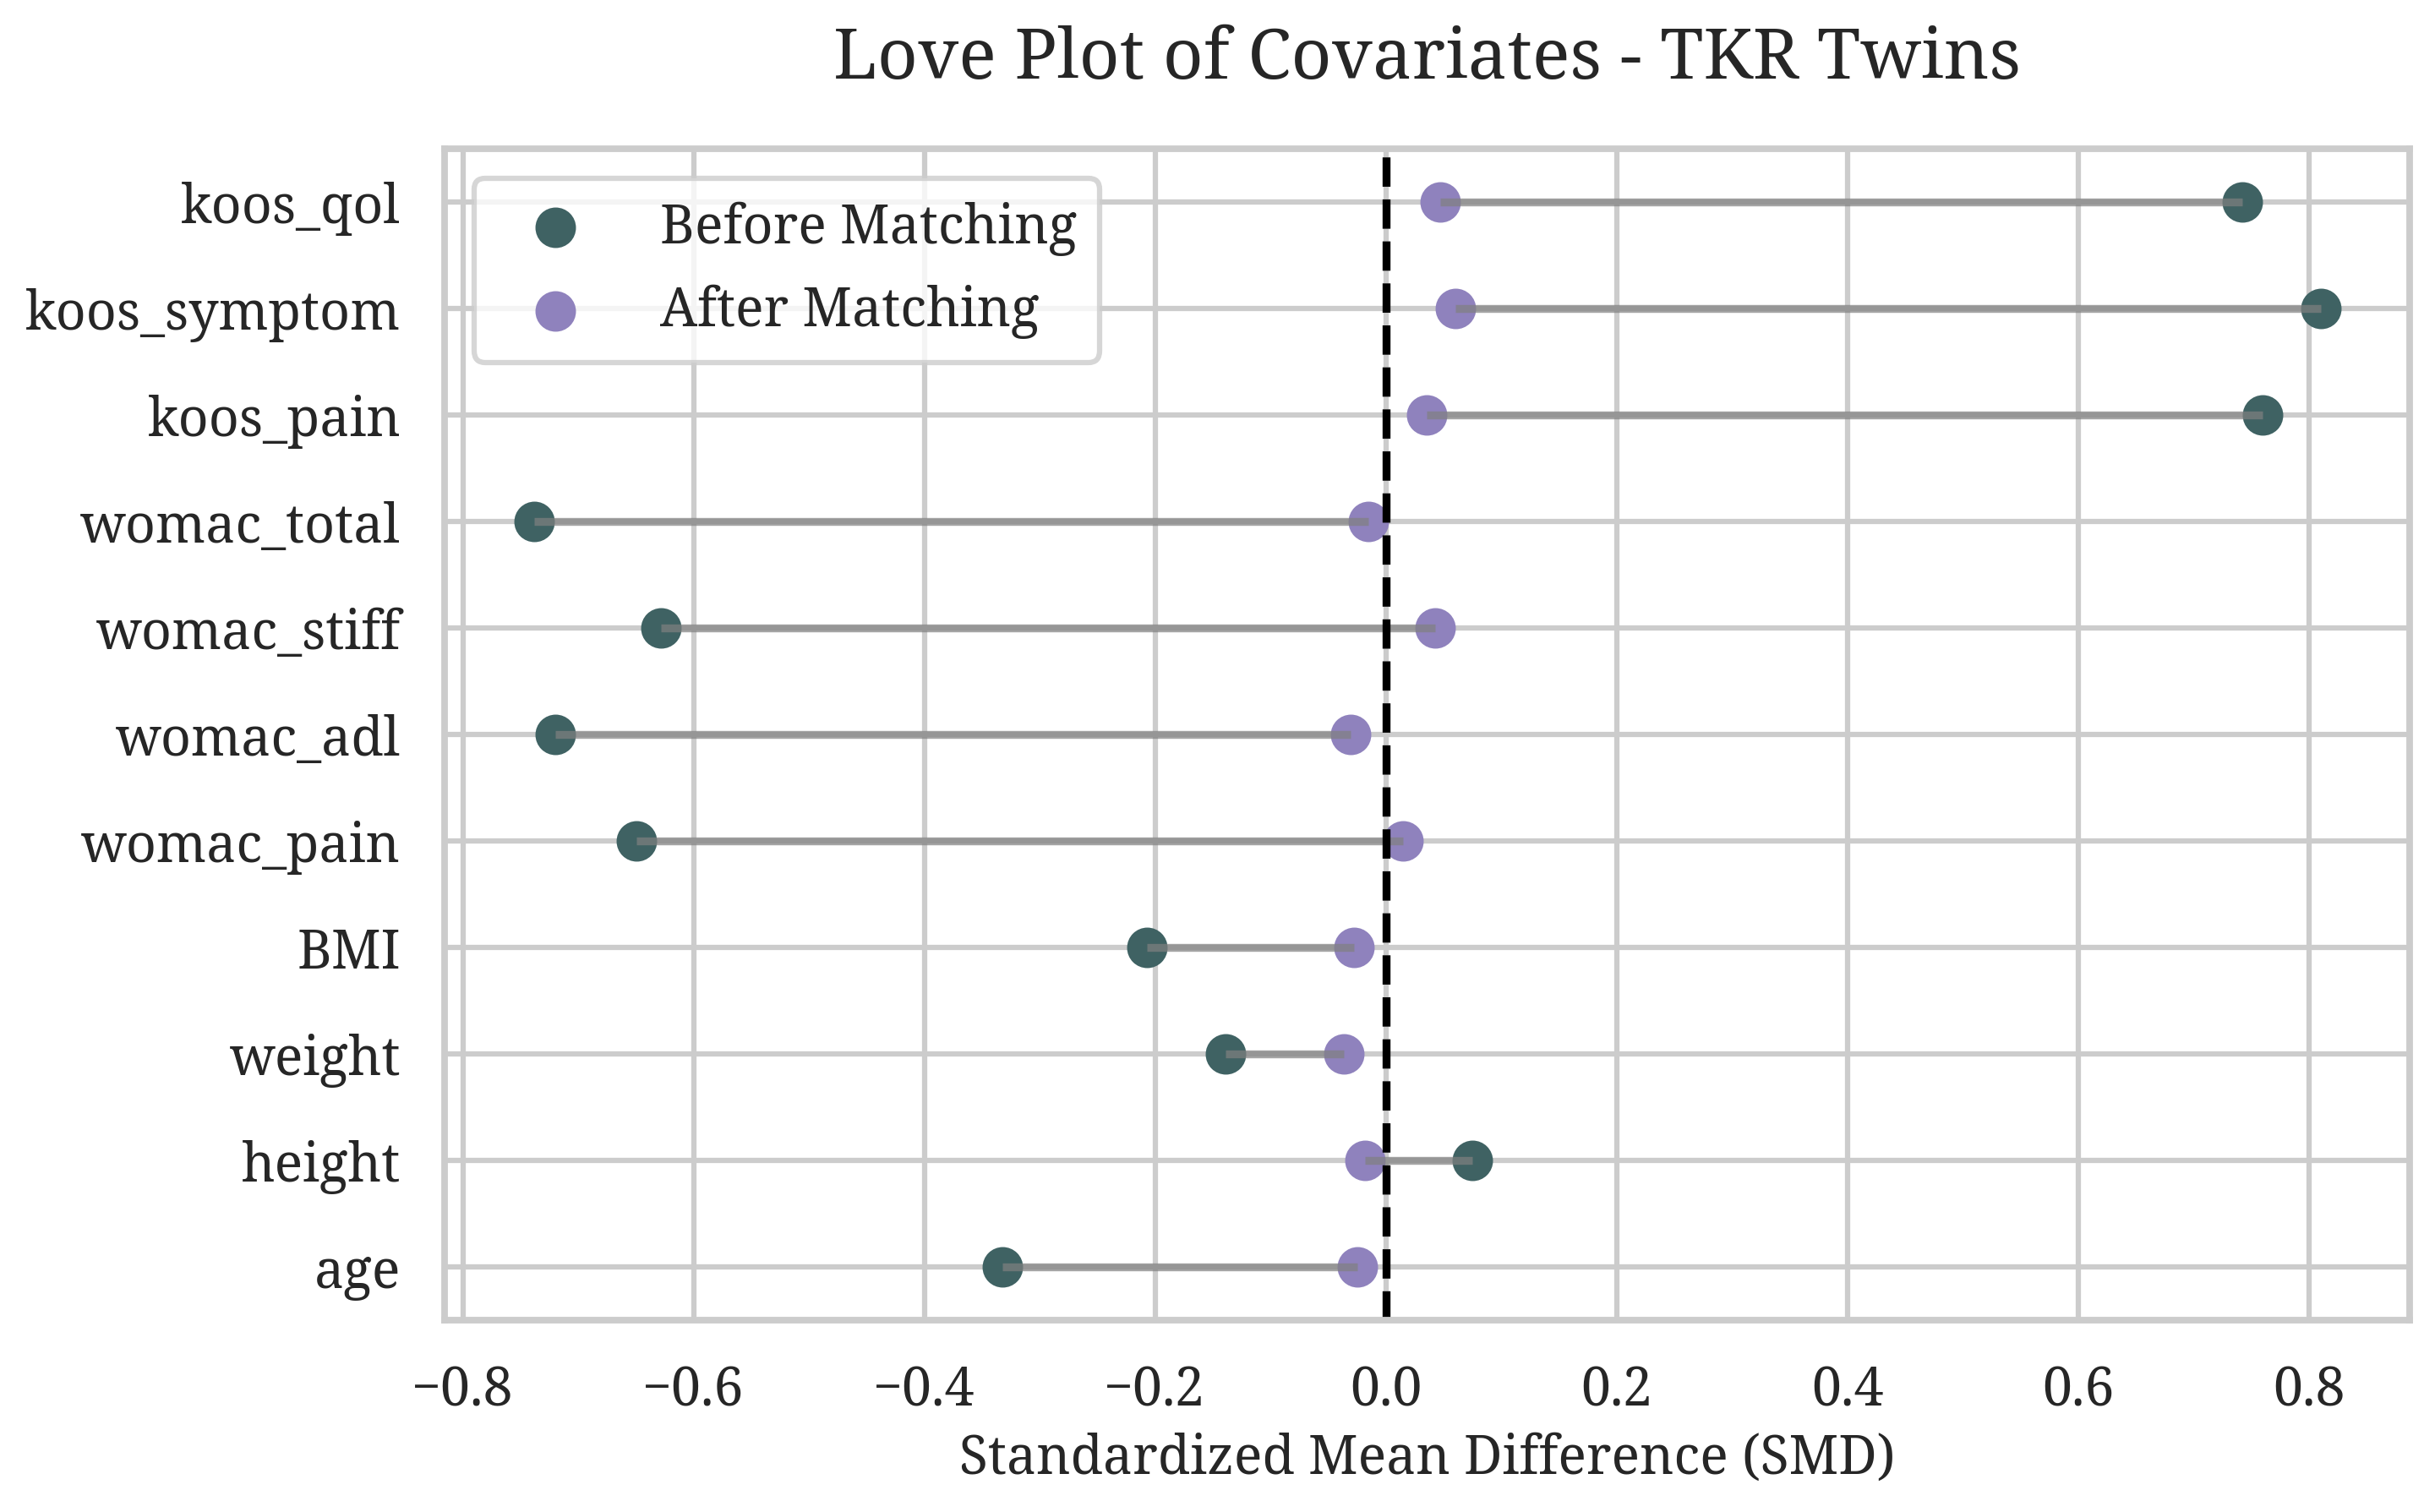

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.font_manager as fm
path = '/usr/share/fonts/truetype/NotoSerif-Regular.ttf'
fontprop = fm.FontProperties(fname=path, size= 15)

after_color = '#8f82bd'
before_color = '#3f6263'

df_before = tkr_before_match.iloc[:,16:-110]
df_after = tkr_matched_df.iloc[:,17:-110]

# Separate df_before into control and treatment groups
df_before_control = tkr_before_match[tkr_before_match['tkr'] == 0]
df_before_treatment = tkr_before_match[tkr_before_match['tkr'] == 1]

# Separate df_after into control and treatment groups
df_after_control = tkr_matched_df[tkr_matched_df['tkr'] == 0]
df_after_treatment = tkr_matched_df[tkr_matched_df['tkr'] == 1]

# Let's assume df_before and df_after have the same structure and the same covariates
covariates = df_before.columns  # list of covariate names

def standardized_mean_difference(df1, df2, variable):
    """Calculate the standardized mean difference for a variable."""
    mean1, mean2 = df1[variable].mean(), df2[variable].mean()
    pooled_std = np.sqrt((df1[variable].std()**2 + df2[variable].std()**2) / 2)
    return (mean1 - mean2) / pooled_std

# Calculate SMD for each covariate before and after matching
smd_before = [standardized_mean_difference(df_before_control, df_before_treatment, var) for var in covariates]
smd_after = [standardized_mean_difference(df_after_control, df_after_treatment, var) for var in covariates]

# Creating the love plot
# plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
ax.hlines(y=covariates, xmin=smd_before, xmax=smd_after, color='grey', alpha=0.7)
ax.scatter(smd_before, covariates, color=before_color, alpha=1, label='Before Matching',  s=100)
ax.scatter(smd_after, covariates, color=after_color, alpha=1, label='After Matching',  s=100)
ax.axvline(x=0, color='black', linestyle='--')

# Plot settings
plt.xlabel('Standardized Mean Difference (SMD)', fontproperties=fontprop)
plt.title('Love Plot of Covariates - TKR Twins', fontproperties=fontprop, fontsize=20, pad=20)
plt.legend()

plt.setp(ax.get_legend().get_texts(),fontproperties=fontprop) # legend text
plt.setp(ax.get_legend().get_title(), fontproperties=fontprop)

# If you want to change the font family for tick labels:
for label in ax.get_xticklabels():
    label.set_fontproperties(fontprop)
for label in ax.get_yticklabels():
    label.set_fontproperties(fontprop)

# plt.savefig('/content/drive/MyDrive/Colab_Notebooks/oai/figures/TKR_numerical_Love_plot.svg', format='svg', bbox_inches='tight')

plt.show()

**other Effect size plot before and after matching**

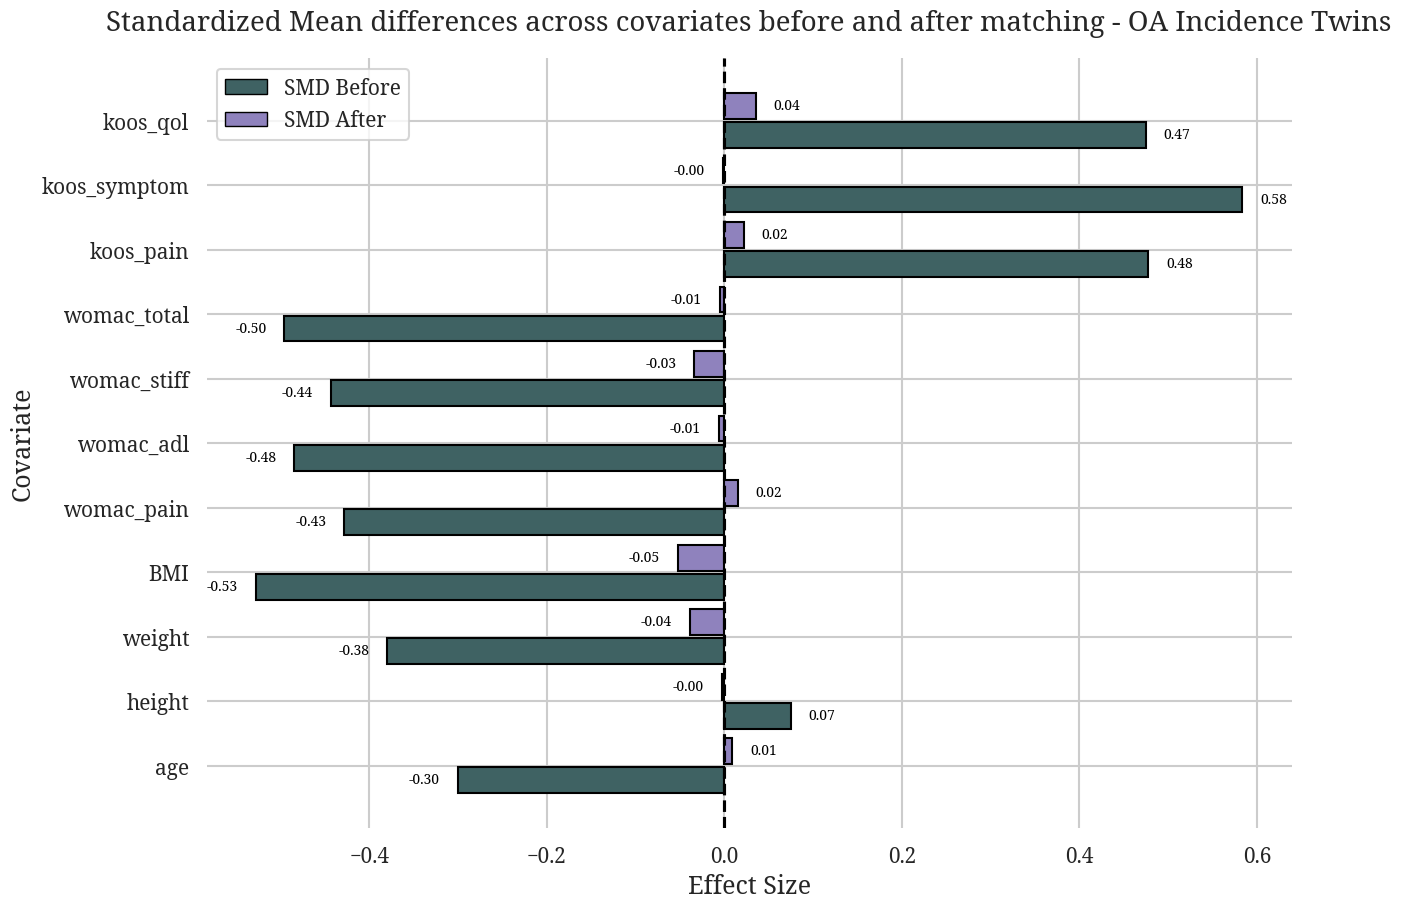

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.font_manager as fm
path = '/usr/share/fonts/truetype/NotoSerif-Regular.ttf'
fontprop = fm.FontProperties(fname=path, size= 15)

after_color = '#8f82bd'
before_color = '#3f6263'

df_before = oa_inc_before_match.iloc[:,16:-110]
df_after = oa_inc_matched_df.iloc[:,17:-110]

# Separate df_before into control and treatment groups
df_before_control = oa_inc_before_match[oa_inc_before_match['oa_prog'] == 0]
df_before_treatment = oa_inc_before_match[oa_inc_before_match['oa_prog'] == 1]

# Separate df_after into control and treatment groups
df_after_control = oa_inc_matched_df[oa_inc_matched_df['oa_prog'] == 0]
df_after_treatment = oa_inc_matched_df[oa_inc_matched_df['oa_prog'] == 1]

# Let's assume df_before and df_after have the same structure and the same covariates
covariates = df_before.columns  # list of covariate names

def standardized_mean_difference(df1, df2, variable):
    """Calculate the standardized mean difference for a variable."""
    mean1, mean2 = df1[variable].mean(), df2[variable].mean()
    pooled_std = np.sqrt((df1[variable].std()**2 + df2[variable].std()**2) / 2)
    return (mean1 - mean2) / pooled_std

# Calculate SMD for each covariate before and after matching
smd_before = [standardized_mean_difference(df_before_control, df_before_treatment, var) for var in covariates]
smd_after = [standardized_mean_difference(df_after_control, df_after_treatment, var) for var in covariates]

# Create a DataFrame from the SMD values
smd_df = pd.DataFrame({
    'Covariate': covariates,
    'SMD Before': smd_before,
    'SMD After': smd_after
})

# Melt the DataFrame to long format for easier plotting with seaborn
smd_df_long = smd_df.melt(id_vars='Covariate', value_vars=['SMD Before', 'SMD After'],
                          var_name='Condition', value_name='SMD')

sns.set_context("talk")
sns.set_style("whitegrid")

f, ax = plt.subplots(figsize=(14, 10))

# Define the bar width and the separation between bars
bar_width = 0.4
separation = 0.05

# Define a function to calculate the fixed offset for text labels
def calculate_offset(max_value, fixed_distance=0.02):
    # Add a fixed distance to the max_value for the offset
    # scale_factor=0.06
    # return abs(value) * scale_factor
    return fixed_distance

# Adding text labels with increased fontsize and offset
for i, covariate in enumerate(covariates):
    before_value = smd_df_long[(smd_df_long['Covariate'] == covariate) & (smd_df_long['Condition'] == 'SMD Before')]['SMD'].values[0]
    after_value = smd_df_long[(smd_df_long['Covariate'] == covariate) & (smd_df_long['Condition'] == 'SMD After')]['SMD'].values[0]

    # The maximum SMD value for this pair of bars, for scaling the offset
    max_smd_value = max(abs(before_value), abs(after_value))

    # Calculate the bar positions
    before_position = i - (bar_width + separation) / 2
    after_position = i + (bar_width + separation) / 2

    # Plot the bars
    ax.barh(before_position, before_value, height=bar_width, color=before_color, edgecolor='black')
    ax.barh(after_position, after_value, height=bar_width, color=after_color, edgecolor='black')

    # Calculate dynamic offsets for the text labels
    before_offset = calculate_offset(before_value)
    after_offset = calculate_offset(after_value)

    # Add data labels if the bars are short
    ax.text(before_value - before_offset if before_value < 0 else before_value + before_offset,
            before_position, f"{before_value:.2f}", va='center', ha='right' if before_value < 0 else 'left',
            color='black', fontsize=10, fontproperties=fontprop)

    ax.text(after_value + after_offset if after_value > 0 else after_value - after_offset,
            after_position, f"{after_value:.2f}", va='center', ha='left' if after_value > 0 else 'right',
            color='black', fontsize=10, fontproperties=fontprop)

# Customize the plot further
ax.axvline(x=0, color='black', linestyle='--')
ax.set_xlabel('Effect Size', fontproperties=fontprop, fontsize=18)
ax.set_ylabel('Covariate', fontproperties=fontprop, fontsize=18)
ax.set_title('Standardized Mean differences across covariates before and after matching - OA Incidence Twins', fontproperties=fontprop, fontsize=20, pad=20)
ax.set(yticks=np.arange(len(covariates)), yticklabels=covariates)
sns.despine(left=True, bottom=True)

# If you want to change the font family for tick labels:
for label in ax.get_xticklabels():
    label.set_fontproperties(fontprop)
for label in ax.get_yticklabels():
    label.set_fontproperties(fontprop)

# Create legend handles explicitly setting facecolor and edgecolor
handle_before = mpatches.Patch(facecolor=before_color, edgecolor='black',
                               label='SMD Before', linewidth=1)
handle_after = mpatches.Patch(facecolor=after_color, edgecolor='black',
                              label='SMD After', linewidth=1)

# Add the legend to the plot with customized handles
ax.legend(handles=[handle_before, handle_after], prop=fontprop)

# plt.savefig('/content/drive/MyDrive/Colab_Notebooks/oai/figures/OA_Inc_numerical_SMD_barplot_effectSize_plot.svg', format='svg', bbox_inches='tight')

# Show the plot
plt.show()


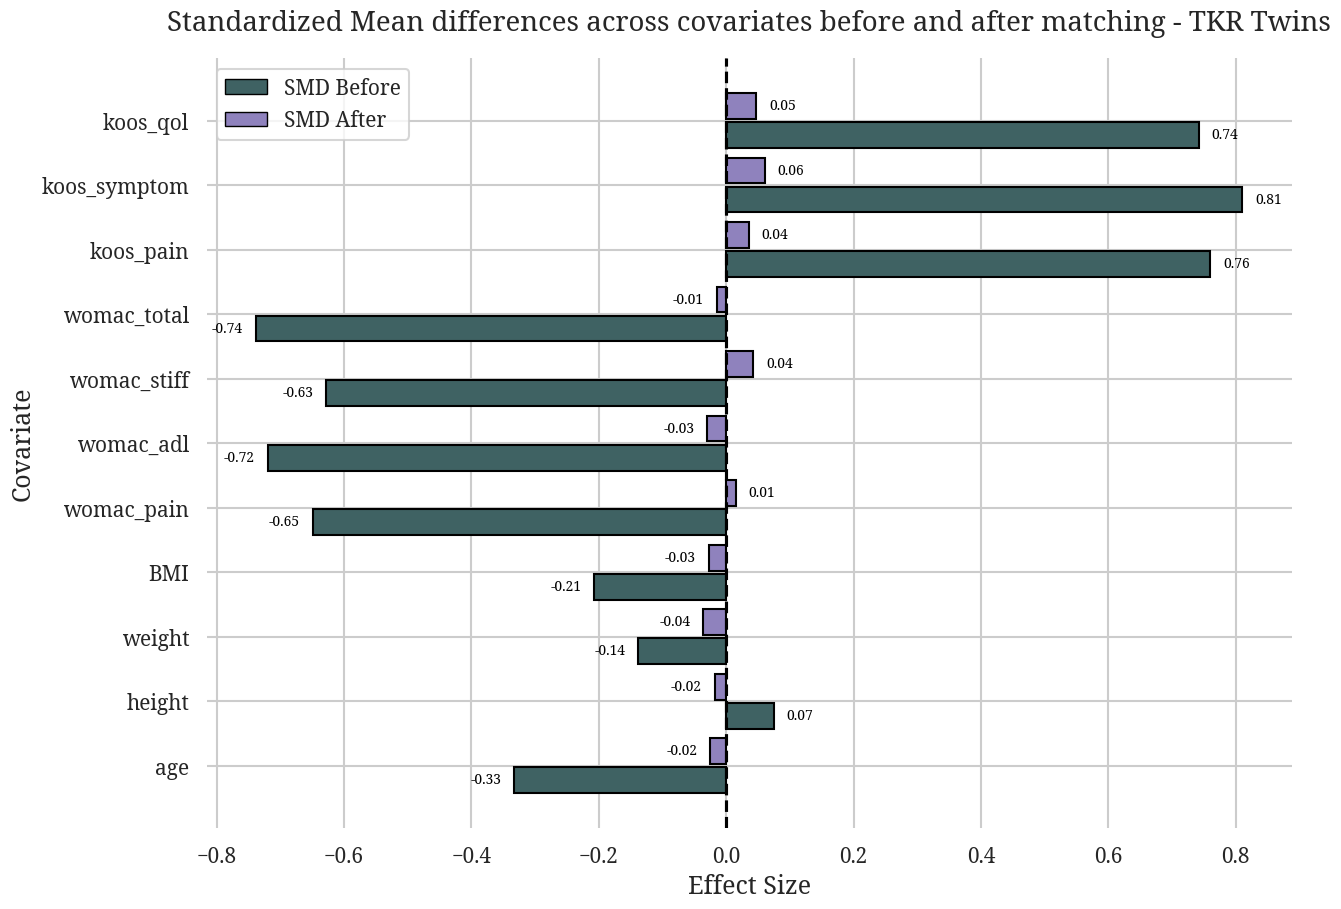

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.font_manager as fm
path = '/usr/share/fonts/truetype/NotoSerif-Regular.ttf'
fontprop = fm.FontProperties(fname=path, size= 15)

after_color = '#8f82bd'
before_color = '#3f6263'

df_before = tkr_before_match.iloc[:,16:-110]
df_after = tkr_matched_df.iloc[:,17:-110]

# Separate df_before into control and treatment groups
df_before_control = tkr_before_match[tkr_before_match['tkr'] == 0]
df_before_treatment = tkr_before_match[tkr_before_match['tkr'] == 1]

# Separate df_after into control and treatment groups
df_after_control = tkr_matched_df[tkr_matched_df['tkr'] == 0]
df_after_treatment = tkr_matched_df[tkr_matched_df['tkr'] == 1]

# Let's assume df_before and df_after have the same structure and the same covariates
covariates = df_before.columns  # list of covariate names

def standardized_mean_difference(df1, df2, variable):
    """Calculate the standardized mean difference for a variable."""
    mean1, mean2 = df1[variable].mean(), df2[variable].mean()
    pooled_std = np.sqrt((df1[variable].std()**2 + df2[variable].std()**2) / 2)
    return (mean1 - mean2) / pooled_std

# Calculate SMD for each covariate before and after matching
smd_before = [standardized_mean_difference(df_before_control, df_before_treatment, var) for var in covariates]
smd_after = [standardized_mean_difference(df_after_control, df_after_treatment, var) for var in covariates]

# Create a DataFrame from the SMD values
smd_df = pd.DataFrame({
    'Covariate': covariates,
    'SMD Before': smd_before,
    'SMD After': smd_after
})

# Melt the DataFrame to long format for easier plotting with seaborn
smd_df_long = smd_df.melt(id_vars='Covariate', value_vars=['SMD Before', 'SMD After'],
                          var_name='Condition', value_name='SMD')

sns.set_context("talk")
sns.set_style("whitegrid")

f, ax = plt.subplots(figsize=(14, 10))

# Define the bar width and the separation between bars
bar_width = 0.4
separation = 0.05

# Define a function to calculate the fixed offset for text labels
def calculate_offset(max_value, fixed_distance=0.02):
    return fixed_distance

# Adding text labels with increased fontsize and offset
for i, covariate in enumerate(covariates):
    before_value = smd_df_long[(smd_df_long['Covariate'] == covariate) & (smd_df_long['Condition'] == 'SMD Before')]['SMD'].values[0]
    after_value = smd_df_long[(smd_df_long['Covariate'] == covariate) & (smd_df_long['Condition'] == 'SMD After')]['SMD'].values[0]

    # The maximum SMD value for this pair of bars, for scaling the offset
    max_smd_value = max(abs(before_value), abs(after_value))

    # Calculate the bar positions
    before_position = i - (bar_width + separation) / 2
    after_position = i + (bar_width + separation) / 2

    # Plot the bars
    ax.barh(before_position, before_value, height=bar_width, color=before_color, edgecolor='black')
    ax.barh(after_position, after_value, height=bar_width, color=after_color, edgecolor='black')

    # Calculate dynamic offsets for the text labels
    before_offset = calculate_offset(before_value)
    after_offset = calculate_offset(after_value)

    # Add data labels if the bars are short
    ax.text(before_value - before_offset if before_value < 0 else before_value + before_offset,
            before_position, f"{before_value:.2f}", va='center', ha='right' if before_value < 0 else 'left',
            color='black', fontsize=10, fontproperties=fontprop)

    ax.text(after_value + after_offset if after_value > 0 else after_value - after_offset,
            after_position, f"{after_value:.2f}", va='center', ha='left' if after_value > 0 else 'right',
            color='black', fontsize=10, fontproperties=fontprop)

# Customize the plot further
ax.axvline(x=0, color='black', linestyle='--')
ax.set_xlabel('Effect Size', fontproperties=fontprop, fontsize=18)
ax.set_ylabel('Covariate', fontproperties=fontprop, fontsize=18)
ax.set_title('Standardized Mean differences across covariates before and after matching - TKR Twins', fontproperties=fontprop, fontsize=20, pad=20)
ax.set(yticks=np.arange(len(covariates)), yticklabels=covariates)
sns.despine(left=True, bottom=True)

# If you want to change the font family for tick labels:
for label in ax.get_xticklabels():
    label.set_fontproperties(fontprop)
for label in ax.get_yticklabels():
    label.set_fontproperties(fontprop)

# Create legend handles explicitly setting facecolor and edgecolor
handle_before = mpatches.Patch(facecolor=before_color, edgecolor='black',
                               label='SMD Before', linewidth=1)
handle_after = mpatches.Patch(facecolor=after_color, edgecolor='black',
                              label='SMD After', linewidth=1)

# Add the legend to the plot with customized handles
ax.legend(handles=[handle_before, handle_after], prop=fontprop)


# plt.savefig('/content/drive/MyDrive/Colab_Notebooks/oai/figures/TKR_numerical_SMD_barplot_effectSize_plot.svg', format='svg', bbox_inches='tight')

# Show the plot
plt.show()


**Bar Plots**

name dictionary

In [ ]:
cat_names = {
  'hisp': 'Hispanic',
  'race': 'Race',
  'gender': 'Sex',
  'Tenderness': 'Joint Line Tenderness',
  'Injury_history': 'Injury History',
  'Mild_symptoms': 'Mild Knee Pain Symptoms',
  'Heberden': 'Heberden',
  'Crepitus': 'Crepitus',
  'Morning_stiffness': 'Morning Stiffness'
}

fix x-label category tick labels

In [ ]:

# Define your tick_names dictionary
tick_names = {
    'hisp': {0: 'Not-Hispanic', 1: 'Latino Hispanic'},
    'Heberden': {0: 'No', 1: 'Yes'},
    'race': {0: 'Other: non-White', 1: 'White', 2: 'Black', 3: 'Asian'},
    'gender': {0: 'Male', 1: 'Female'},
    'Tenderness': {0: 'No', 1: 'Yes'},
    'Mild_symptoms': {0: 'No', 1: 'Yes'},
    'Crepitus': {0: 'No', 1: 'Yes'},
    'Injury_history': {0: '0', 1: '1'},
    'Morning_stiffness': {0: '0', 1: '1'}
}


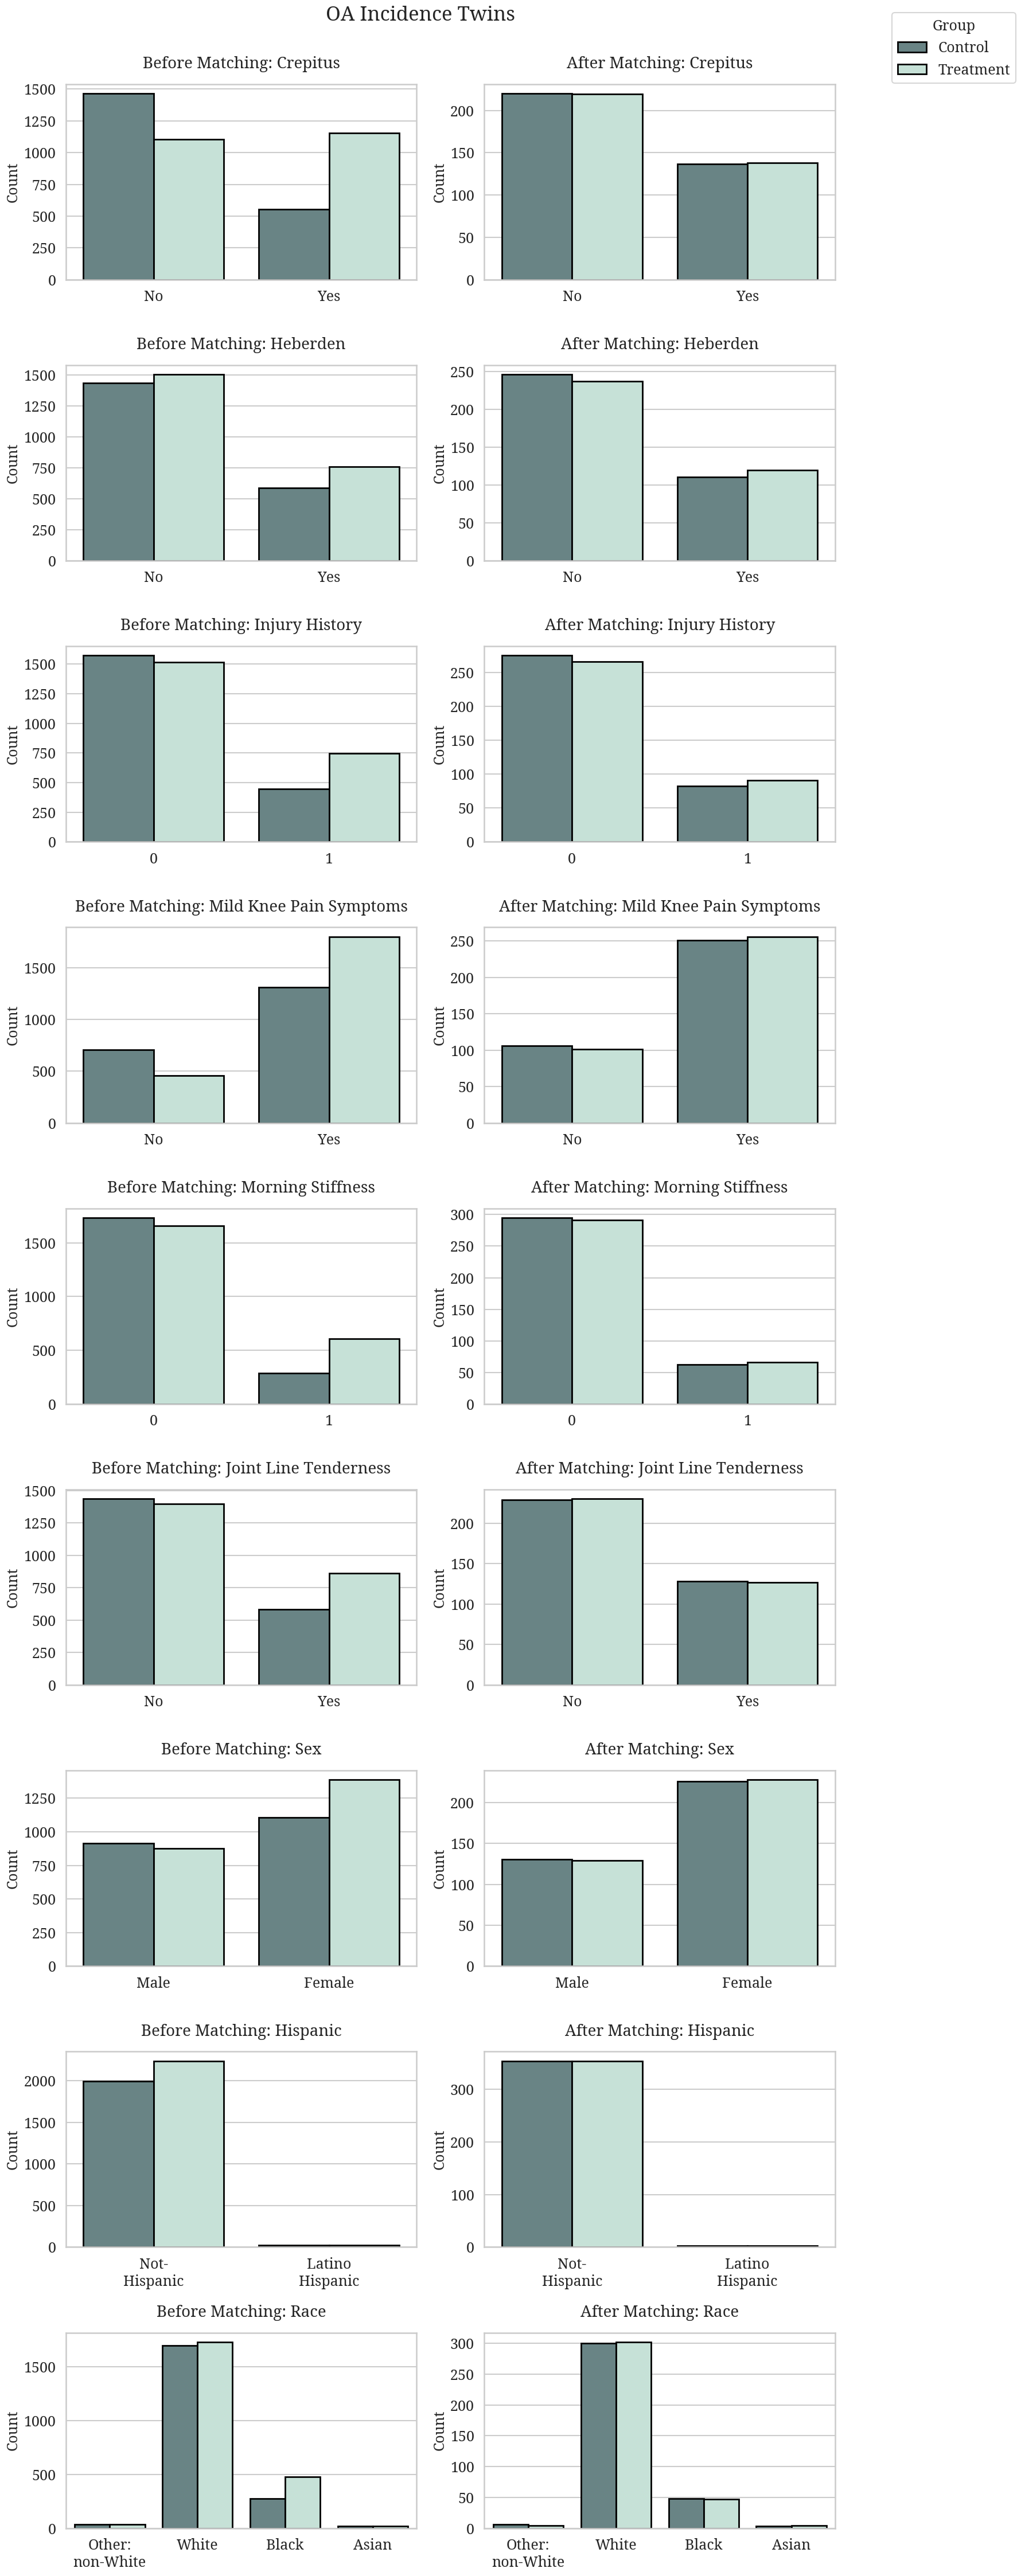

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import textwrap

import matplotlib.font_manager as fm
path = '/usr/share/fonts/truetype/NotoSerif-Regular.ttf'
fontprop = fm.FontProperties(fname=path, size= 18)

oa_inc_before_match.iloc[:,7:16] = oa_inc_before_match.iloc[:,7:16].astype(float).astype(int)
oa_inc_matched_df.iloc[:,8:17] = oa_inc_matched_df.iloc[:,8:17].astype(float).astype(int)

# categorical variabes:
df_before = oa_inc_before_match.iloc[:,7:16]
df_after = oa_inc_matched_df.iloc[:,8:17]

# Separate df_before into control and treatment groups
df_before_control = oa_inc_before_match[oa_inc_before_match['oa_prog'] == 0].iloc[:,7:16]
df_before_treatment = oa_inc_before_match[oa_inc_before_match['oa_prog'] == 1].iloc[:,7:16]

# Separate df_after into control and treatment groups
df_after_control = oa_inc_matched_df[oa_inc_matched_df['oa_prog'] == 0].iloc[:,8:17]
df_after_treatment = oa_inc_matched_df[oa_inc_matched_df['oa_prog'] == 1].iloc[:,8:17]

# Combine and melt the dataframes
combined_df = pd.concat([
    df_before_control.assign(Group='Control', Time='Before'),
    df_before_treatment.assign(Group='Treatment', Time='Before'),
    df_after_control.assign(Group='Control', Time='After'),
    df_after_treatment.assign(Group='Treatment', Time='After')
])

# Melt to long format
melted_df = combined_df.melt(id_vars=['Group', 'Time'], var_name='Variable', value_name='Value')

# Count the frequency for each category
count_df = melted_df.groupby(['Variable', 'Value', 'Group', 'Time']).size().reset_index(name='Count')

# Define the custom color palette
cmap = sns.cubehelix_palette(start=.5, rot=-.5)
oa_incidence_color = cmap[0]
control_color = '#64888A'  # Darker color for the

# Color palette
my_palette = [control_color, oa_incidence_color]

# Get the list of variables
variables = count_df['Variable'].unique()

# Set up the matplotlib figure with two columns
sns.set_context("talk")
sns.set_style("whitegrid")  # Optionally set a background style

n_vars = len(variables)
fig, axes = plt.subplots(n_vars, 2, figsize=(15, 5 * n_vars))  # Adjust figsize as needed

# Create a bar plot for each variable in each time period
for i, variable in enumerate(variables):
    # Plot for 'Before' matching
    sns.barplot(x='Value', y='Count', hue='Group',
                data=count_df[(count_df['Variable'] == variable) & (count_df['Time'] == 'Before')],
                ax=axes[i, 0], palette=my_palette, edgecolor="black", linewidth=2)

    # Set the titles using the names dictionary and wrap the text
    title_text = cat_names.get(variable, variable)  # Default to col_name if not found in dictionary
    wrapped_title = "\n".join(textwrap.wrap(title_text, width=30))  # Adjust 'width' as needed
    axes[i, 0].set_title(f'Before Matching: {wrapped_title}', fontproperties=fontprop, pad=20, fontsize=20)
    axes[i, 0].set_xlabel('', fontproperties=fontprop, fontsize=18)
    axes[i, 0].set_ylabel('Count', fontproperties=fontprop, fontsize=18)

    # Plot for 'After' matching
    sns.barplot(x='Value', y='Count', hue='Group',
                data=count_df[(count_df['Variable'] == variable) & (count_df['Time'] == 'After')],
                ax=axes[i, 1], palette=my_palette, edgecolor="black", linewidth=2)

    axes[i, 1].set_title(f'After Matching: {wrapped_title}', fontproperties=fontprop, pad=20, fontsize=20)
    axes[i, 1].set_xlabel('', fontproperties=fontprop, fontsize=18)
    axes[i, 1].set_ylabel('Count', fontproperties=fontprop, fontsize=18)

    # Remove the legend for the 'Before' subplot
    axes[i, 0].legend().remove()

    # Remove the legend for the 'After' subplot
    axes[i, 1].legend().remove()

    if variable in tick_names:
        # For 'Before' subplot
        # Get the current tick locations
        locs = axes[i, 0].get_xticks()
        # Generate wrapped labels
        wrapped_labels = [textwrap.fill(tick_names[variable][item], width=10) for item in locs if item in tick_names[variable]]
        axes[i, 0].set_xticklabels(wrapped_labels, fontproperties=fontprop)

        # For 'After' subplot
        # Get the current tick locations
        locs = axes[i, 1].get_xticks()
        # Generate wrapped labels
        wrapped_labels = [textwrap.fill(tick_names[variable][item], width=10) for item in locs if item in tick_names[variable]]
        axes[i, 1].set_xticklabels(wrapped_labels, fontproperties=fontprop)

    # If you want to change the font family for tick labels:
    for label in axes[i, 0].get_xticklabels():
        label.set_fontproperties(fontprop)
    for label in axes[i, 0].get_yticklabels():
        label.set_fontproperties(fontprop)

        # If you want to change the font family for tick labels:
    for label in axes[i, 1].get_xticklabels():
        label.set_fontproperties(fontprop)
    for label in axes[i, 1].get_yticklabels():
        label.set_fontproperties(fontprop)

# After the loop, create a single legend for the 'After' subplots
# Choose one of the 'After' subplots to extract the handles and labels for the legend
handles, labels = axes[0, 1].get_legend_handles_labels()

# Create the global figure legend with these handles and labels
leg = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.12, 1), title='Group', prop=fontprop)

plt.setp(leg.get_texts(),fontproperties=fontprop) # legend text
plt.setp(leg.get_title(), fontproperties=fontprop)

plt.suptitle('OA Incidence Twins', y=1, fontproperties=fontprop, fontsize=25)

plt.tight_layout()

# plt.savefig('/content/drive/MyDrive/Colab_Notebooks/oai/figures/OA_Inc_categorical_bar_plot.svg', format='svg', bbox_inches='tight')

plt.show()

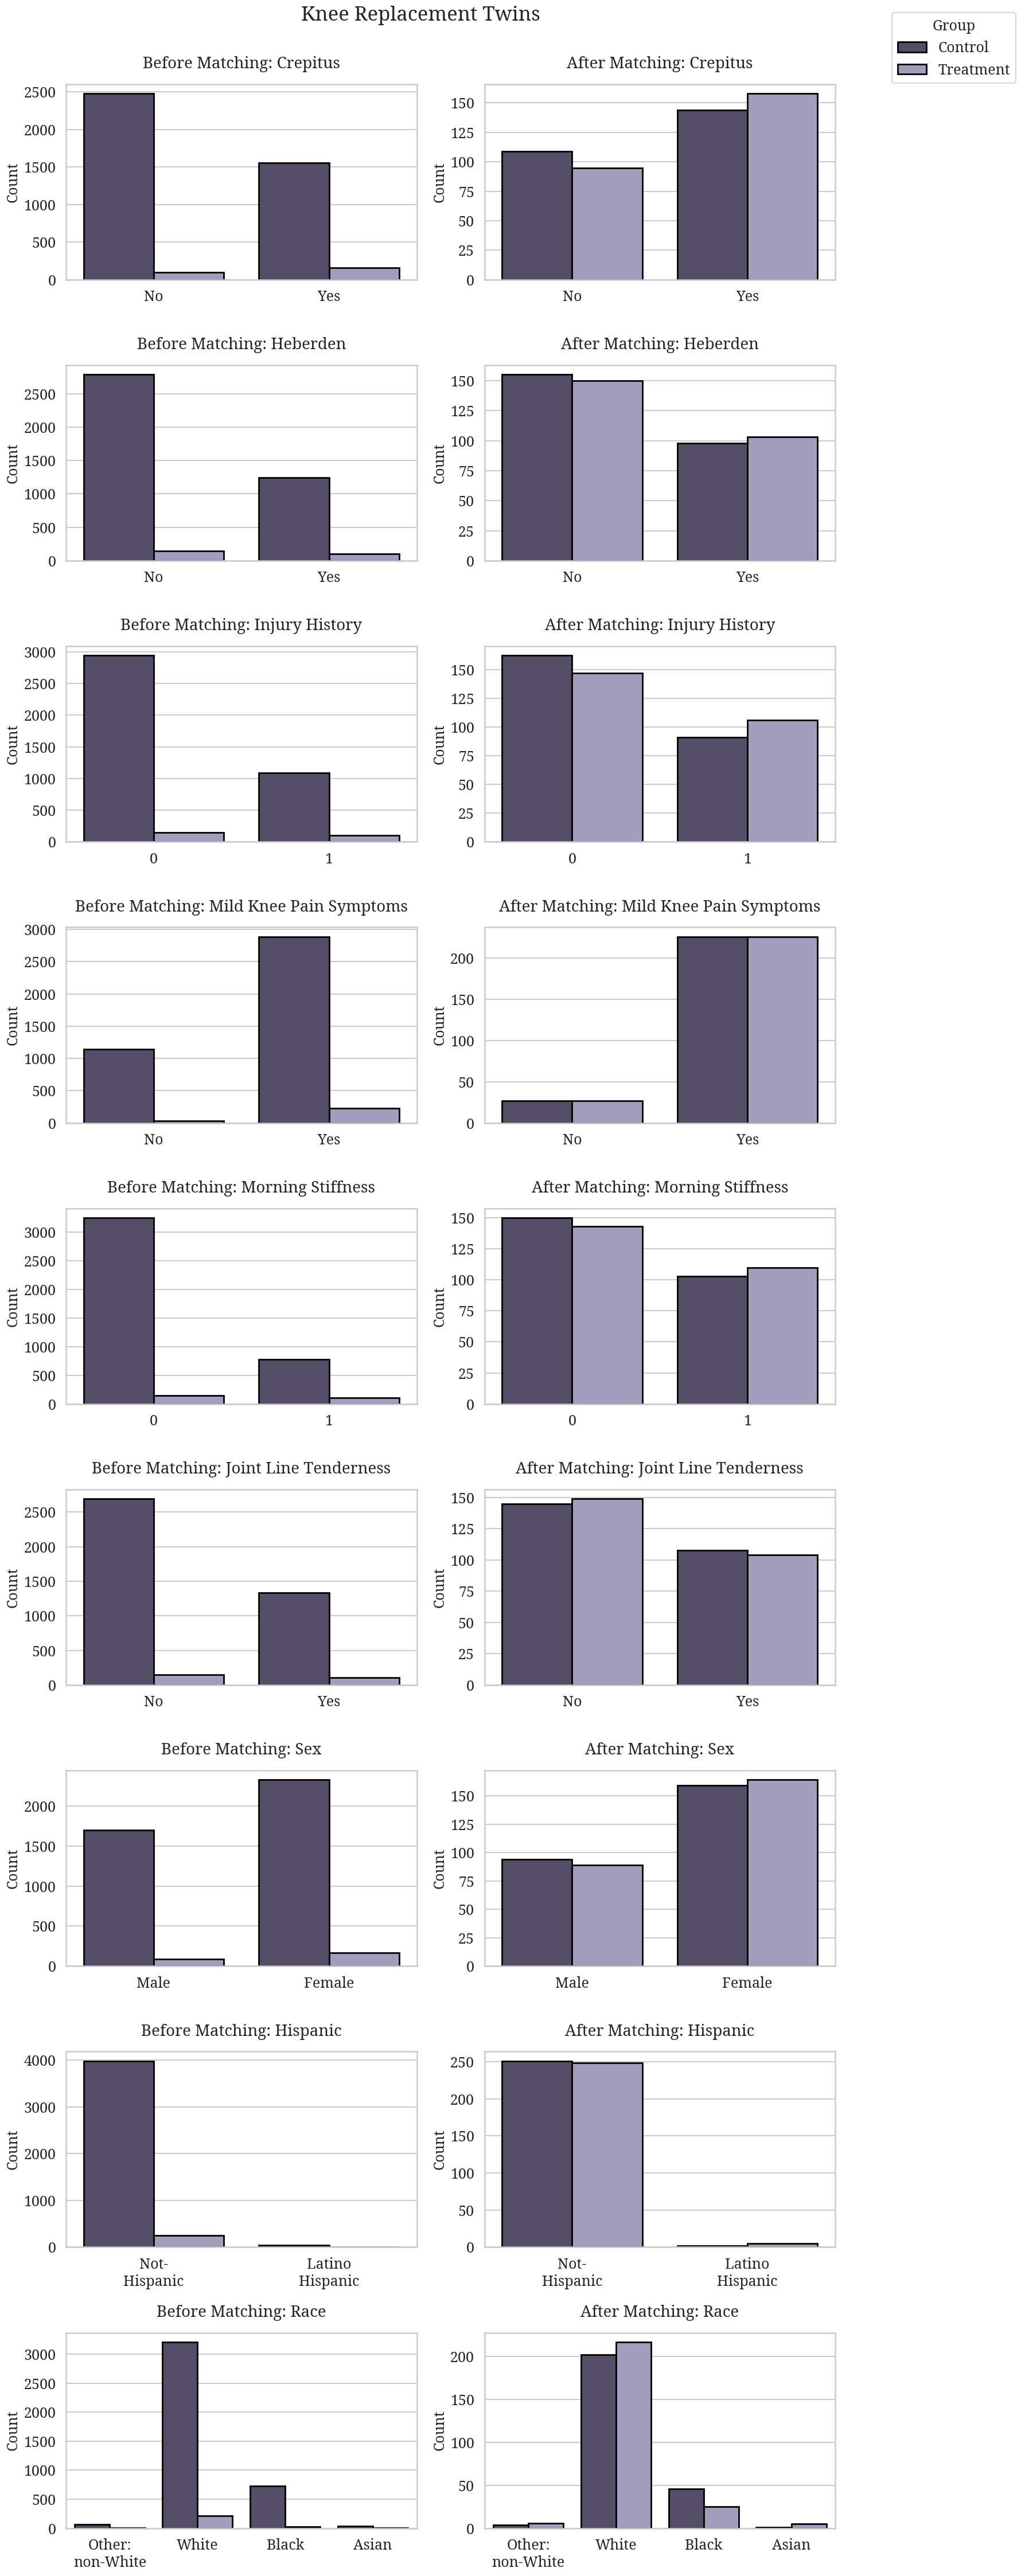

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import textwrap

import matplotlib.font_manager as fm
path = '/usr/share/fonts/truetype/NotoSerif-Regular.ttf'
fontprop = fm.FontProperties(fname=path, size= 18)

tkr_before_match.iloc[:,7:16] = tkr_before_match.iloc[:,7:16].astype(float).astype(int)
tkr_matched_df.iloc[:,8:17] = tkr_matched_df.iloc[:,8:17].astype(float).astype(int)

# categorical variabes:
df_before = tkr_before_match.iloc[:,7:16]
df_after = tkr_matched_df.iloc[:,8:17]

# Separate df_before into control and treatment groups
df_before_control = tkr_before_match[tkr_before_match['tkr'] == 0].iloc[:,7:16]
df_before_treatment = tkr_before_match[tkr_before_match['tkr'] == 1].iloc[:,7:16]

# Separate df_after into control and treatment groups
df_after_control = tkr_matched_df[tkr_matched_df['tkr'] == 0].iloc[:,8:17]
df_after_treatment = tkr_matched_df[tkr_matched_df['tkr'] == 1].iloc[:,8:17]

# Combine and melt the dataframes
combined_df = pd.concat([
    df_before_control.assign(Group='Control', Time='Before'),
    df_before_treatment.assign(Group='Treatment', Time='Before'),
    df_after_control.assign(Group='Control', Time='After'),
    df_after_treatment.assign(Group='Treatment', Time='After')
])

# Melt to long format
melted_df = combined_df.melt(id_vars=['Group', 'Time'], var_name='Variable', value_name='Value')

# Count the frequency for each category
count_df = melted_df.groupby(['Variable', 'Value', 'Group', 'Time']).size().reset_index(name='Count')

cmap = sns.cubehelix_palette(start=.5, rot=-.5)
oa_incidence_color = '#9D98C2'  #cmap[0]
control_color = '#50486D'  # Darker color for the

# Color palette
my_palette = [control_color, oa_incidence_color]

# Get the list of variables
variables = count_df['Variable'].unique()

# Set up the matplotlib figure with two columns
sns.set_context("talk")
sns.set_style("whitegrid")  # Optionally set a background style

n_vars = len(variables)
fig, axes = plt.subplots(n_vars, 2, figsize=(15, 5 * n_vars))  # Adjust figsize as needed

# Create a bar plot for each variable in each time period
for i, variable in enumerate(variables):
    # Plot for 'Before' matching
    sns.barplot(x='Value', y='Count', hue='Group',
                data=count_df[(count_df['Variable'] == variable) & (count_df['Time'] == 'Before')],
                ax=axes[i, 0], palette=my_palette, edgecolor="black", linewidth=2)

    # Set the titles using the names dictionary and wrap the text
    title_text = cat_names.get(variable, variable)  # Default to col_name if not found in dictionary
    wrapped_title = "\n".join(textwrap.wrap(title_text, width=30))  # Adjust 'width' as needed
    axes[i, 0].set_title(f'Before Matching: {wrapped_title}', fontproperties=fontprop, pad=20, fontsize=20)
    axes[i, 0].set_xlabel('', fontproperties=fontprop, fontsize=18)
    axes[i, 0].set_ylabel('Count', fontproperties=fontprop, fontsize=18)

    # Plot for 'After' matching
    sns.barplot(x='Value', y='Count', hue='Group',
                data=count_df[(count_df['Variable'] == variable) & (count_df['Time'] == 'After')],
                ax=axes[i, 1], palette=my_palette, edgecolor="black", linewidth=2)

    # axes[i, 1].set_title(f'{variable} - After Matching', fontproperties=fontprop, fontsize=18)
    axes[i, 1].set_title(f'After Matching: {wrapped_title}', fontproperties=fontprop, pad=20, fontsize=20)
    axes[i, 1].set_xlabel('', fontproperties=fontprop, fontsize=18)
    axes[i, 1].set_ylabel('Count', fontproperties=fontprop, fontsize=18)

    # Remove the legend for the 'Before' subplot
    axes[i, 0].legend().remove()

    # Remove the legend for the 'After' subplot
    axes[i, 1].legend().remove()

    if variable in tick_names:
        # For 'Before' subplot
        # Get the current tick locations
        locs = axes[i, 0].get_xticks()
        # Generate wrapped labels
        wrapped_labels = [textwrap.fill(tick_names[variable][item], width=10) for item in locs if item in tick_names[variable]]
        axes[i, 0].set_xticklabels(wrapped_labels, fontproperties=fontprop)

        # For 'After' subplot
        # Get the current tick locations
        locs = axes[i, 1].get_xticks()
        # Generate wrapped labels
        wrapped_labels = [textwrap.fill(tick_names[variable][item], width=10) for item in locs if item in tick_names[variable]]
        axes[i, 1].set_xticklabels(wrapped_labels, fontproperties=fontprop)

    # If you want to change the font family for tick labels:
    for label in axes[i, 0].get_xticklabels():
        label.set_fontproperties(fontprop)
    for label in axes[i, 0].get_yticklabels():
        label.set_fontproperties(fontprop)

        # If you want to change the font family for tick labels:
    for label in axes[i, 1].get_xticklabels():
        label.set_fontproperties(fontprop)
    for label in axes[i, 1].get_yticklabels():
        label.set_fontproperties(fontprop)

# After the loop, create a single legend for the 'After' subplots
# Choose one of the 'After' subplots to extract the handles and labels for the legend
handles, labels = axes[0, 1].get_legend_handles_labels()

# Create the global figure legend with these handles and labels
leg = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.12, 1), title='Group', prop=fontprop)

plt.setp(leg.get_texts(),fontproperties=fontprop) # legend text
plt.setp(leg.get_title(), fontproperties=fontprop)

plt.suptitle('Knee Replacement Twins', y=1, fontproperties=fontprop, fontsize=25)

plt.tight_layout()

# plt.savefig('/content/drive/MyDrive/Colab_Notebooks/oai/figures/TKR_categorical_bar_plot.svg', format='svg', bbox_inches='tight')

plt.show()